# Analyzing DNA binding mutants 

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import pandas as pd
import glob
import sys
sys.path.insert(0, '../../')
import mut.viz
import mut.thermo
import mut.stats
import mut.bayes
colors = mut.viz.pub_style()
%matplotlib inline

In [90]:
# Define the files
files = glob.glob('../../data/csv/2018*.csv')
dfs = [pd.read_csv(i, comment='#') for i in files]
df = pd.concat(dfs, ignore_index=True)

# Remove the auto and delta strains. 
idx_id = {'Q21M':0, 'Q21A':1, 'Y20I':2}

df = df[(df['date'] != 20180311) & (df['mutant'] != 'wt')]
df = df[df['fold_change'] >= 0]
df = df[(df['mutant'] != 'auto') & (df['mutant'] != 'delta')]
df['idx'] = [idx_id[df.iloc[i]['mutant']] for i in range(len(df))]
grouped = df.groupby(['mutant', 'strain', 'IPTG_uM'])


,IPTG_uM,class,date,fold_change,mean_FITC_H,mean_YFP_bgcorr,mutant,operator,repressors,strain,username,idx
2,0.0,NaN,20180202,0.022544,5061.323447,NaN,Q21M,O2,60.0,R60,sbarnes,0
3,0.0,NaN,20180202,0.008672,4814.352752,NaN,Q21M,O2,124.0,R124,sbarnes,0
5,0.0,NaN,20180202,0.012264,4878.298203,NaN,Q21M,O2,260.0,R260,sbarnes,0
8,0.1,NaN,20180202,0.010162,4901.658869,NaN,Q21M,O2,60.0,R60,sbarnes,0
9,0.1,NaN,20180202,0.003349,4762.894867,NaN,Q21M,O2,260.0,R260,sbarnes,0
10,0.1,NaN,20180202,0.010695,4912.508152,NaN,Q21M,O2,124.0,R124,sbarnes,0
16,5.0,NaN,20180202,0.012357,4824.009322,NaN,Q21M,O2,260.0,R260,sbarnes,0
17,5.0,NaN,20180202,0.035043,5328.065554,NaN,Q21M,O2,124.0,R124,sbarnes,0
18,5.0,NaN,20180202,0.015248,4888.248761,NaN,Q21M,O2,60.0,R60,sbarnes,0
21,10.0,NaN,20180202,0.025639,4946.319348,NaN,Q21M,O2,260.0,R260,sbarnes,0


/Users/gchure/anaconda/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


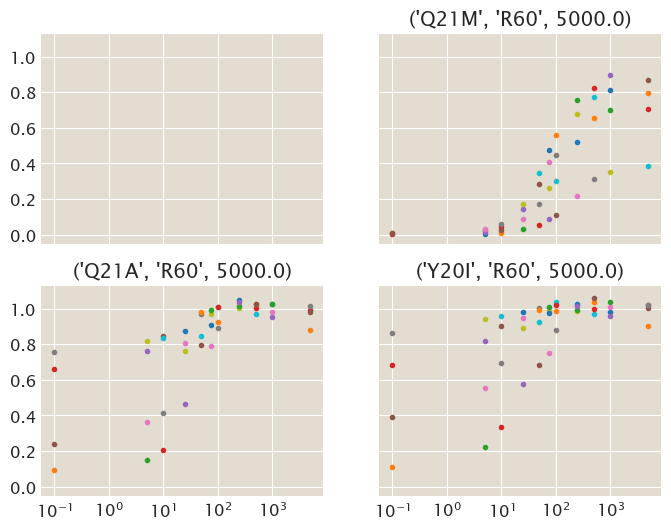

In [91]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
ax = ax.ravel()
axes = {'wt':ax[0], 'Q21M':ax[1], 'Q21A':ax[2], 'Y20I':ax[3]}
for a in ax:
    a.set_xscale('log')
for g, d in grouped:
    axes[g[0]].plot(d['IPTG_uM'].mean(), d['fold_change'].mean(), '.')
    axes[g[0]].set_title(g)

It will be better to fit the log fold change I think. Let's just try things with the WT to make sure they are working as expected. 

In [92]:
# Look only at the leakiness values. 
leakiness = df[(df['IPTG_uM'] == 0) & (df['date']!=20180311) & (df['strain']!='wt')]

In [93]:
# Set up the model.
with pm.Model() as model:
    # Set the priors for the binding energy
    ep = pm.Normal('ep', mu=0, sd=10, shape=3)
    sigma = pm.HalfNormal('sigma', sd=10, shape=3)
    
    # Compute the log fold change.
    idx = leakiness['idx']
    arch = mut.thermo.SimpleRepression(R=leakiness['repressors'].values[idx], ep_r=ep[idx],
                                              ka=153, ki=0.53, ep_ai=4.5, effector_conc=0)
    mu = arch.fold_change()
    
    like = pm.Normal('like', mu=mu, sd=sigma[idx], observed=leakiness['fold_change'].values)
    trace = pm.sample(tune=2000, draws=2000, njobs=2)
    trace_df = mut.stats.trace_to_dataframe(trace, model)
    stats = mut.stats.compute_statistics(trace_df)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_log__, ep]
100%|██████████| 4000/4000 [00:12<00:00, 314.92it/s]
The acceptance probability does not match the target. It is 0.265707289662, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.703075650111, but should be close to 0.8. Try to increase the number of tuning steps.
The estimated number of effective samples is smaller than 200 for some parameters.


In [94]:
pm.gelman_rubin(trace)

{'ep': array([ 1.0032111 ,  1.00004956,  1.00758845]),
 'sigma': array([ 1.00125715,  1.001848  ,  1.00082148])}

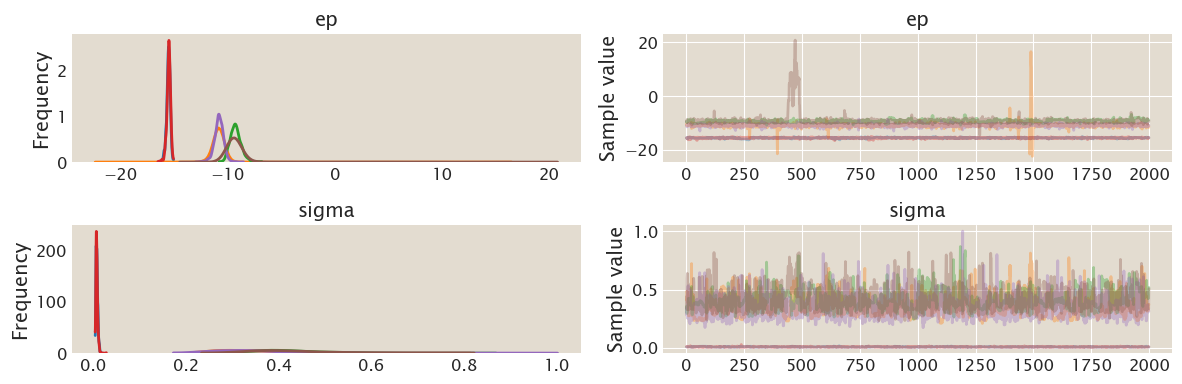

In [102]:
_ = pm.traceplot(trace)

In [103]:
# Extract the modes.
modes = {}
for k, v in idx_id.items():
    modes[k] = stats[stats['parameter']=='ep__{}'.format(v)]['mode'].values[0]

In [141]:
leakiness.repressors.unique().astype(int)

array([  60,  124,  260, 1220])

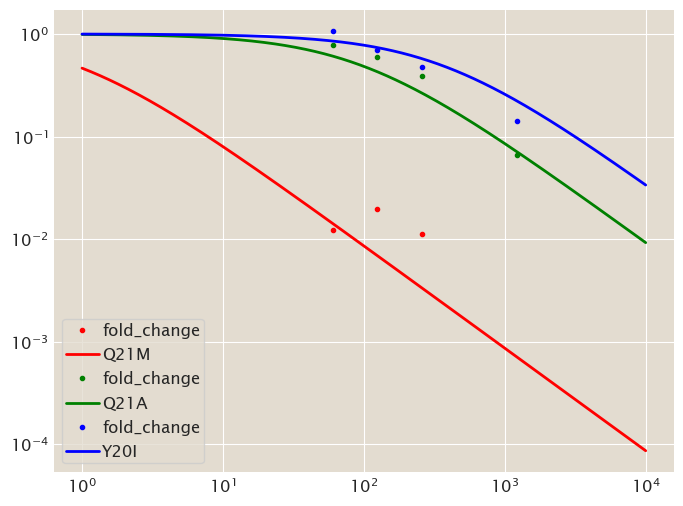

In [105]:
# Plot them. 
colors=['r', 'g', 'b', 'k']
rep_range = np.logspace(0, 4, 500)
for i, k in enumerate(modes.keys()):
    # Grab the data. 
    d = leakiness[leakiness['mutant'] == k].groupby('repressors')['fold_change'].mean()
    plt.loglog(d,'.', color=colors[i])
    theo = mut.thermo.SimpleRepression(R=rep_range, ep_r=modes[k], ka=153, 
                                       ki=0.53, ep_ai=4.5, effector_conc=0) 
    plt.loglog(rep_range, theo.fold_change(), color=colors[i], label=k)

plt.legend()

,IPTG_uM,class,date,fold_change,mean_FITC_H,mean_YFP_bgcorr,mutant,operator,repressors,strain,username,idx
2,0.0,NaN,20180202,0.022544,5061.323447,NaN,Q21M,O2,60.0,R60,sbarnes,0
3,0.0,NaN,20180202,0.008672,4814.352752,NaN,Q21M,O2,124.0,R124,sbarnes,0
5,0.0,NaN,20180202,0.012264,4878.298203,NaN,Q21M,O2,260.0,R260,sbarnes,0
8,0.1,NaN,20180202,0.010162,4901.658869,NaN,Q21M,O2,60.0,R60,sbarnes,0
9,0.1,NaN,20180202,0.003349,4762.894867,NaN,Q21M,O2,260.0,R260,sbarnes,0
10,0.1,NaN,20180202,0.010695,4912.508152,NaN,Q21M,O2,124.0,R124,sbarnes,0
16,5.0,NaN,20180202,0.012357,4824.009322,NaN,Q21M,O2,260.0,R260,sbarnes,0
17,5.0,NaN,20180202,0.035043,5328.065554,NaN,Q21M,O2,124.0,R124,sbarnes,0
18,5.0,NaN,20180202,0.015248,4888.248761,NaN,Q21M,O2,60.0,R60,sbarnes,0
21,10.0,NaN,20180202,0.025639,4946.319348,NaN,Q21M,O2,260.0,R260,sbarnes,0


In [210]:
def compute_mean_sem(df):
    stat_dict = {'mean': np.mean(df), 'sem': np.std(df) / len(df)}
    return pd.Series(stat_dict)

grouped = df.groupby(['mutant', 'repressors', 'IPTG_uM'])['fold_change']

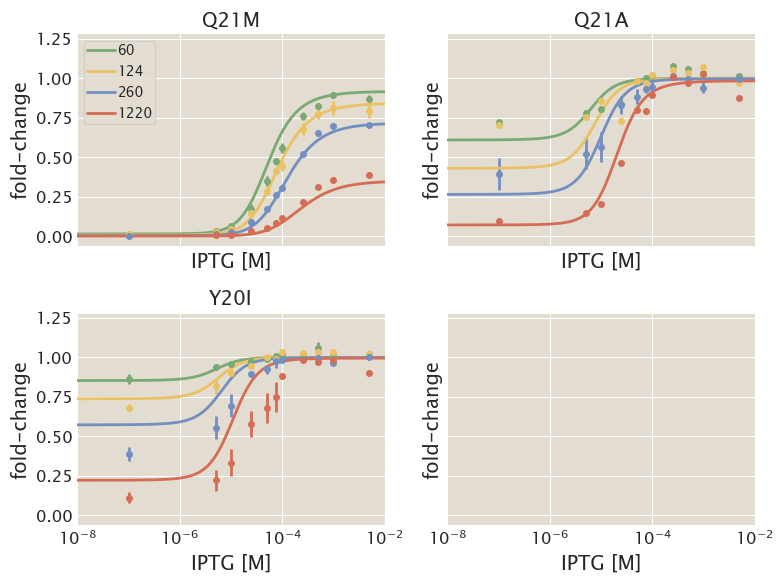

In [233]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6), sharey=True, sharex=True)
ax = ax.ravel()
for a in ax:
    a.set_xscale('log')
    a.set_xlabel('IPTG [M]')
    a.set_ylabel('fold-change')
axes = {'Q21M':ax[0], 'Q21A':ax[1], 'Y20I':ax[2]}
titles = list(axes.keys())
for i in range(3):
    ax[i].set_title(titles[i])

reps = df.repressors.unique()
c_range = np.logspace(-8, -2, 500)
c_map = list(colors.values())[::3]
c_dict = {r:c for r, c in zip(reps, c_map)}
for i, m in enumerate(axes.keys()):
    for j, r in enumerate(reps):
        theo = mut.thermo.SimpleRepression(R=r, ep_ai=4.5, ka=139E-6, ki=0.53E-6, 
                                           effector_conc=c_range, ep_r=modes[m]).fold_change()
        _ = axes[m].plot(c_range, theo, color=c_map[j], label=int(r))

for g, d in grouped:
    _ = axes[g[0]].errorbar(g[2] / 1E6, np.mean(d), np.std(d) / np.sqrt(len(d)), fmt='o', color=c_dict[g[1]], 
                           markersize=4)
_ = ax[0].legend(fontsize=10)

ax[0].set_xlim([1E-8, 1E-2])
plt.tight_layout()

2

In [188]:
b = df.IPTG_uM.unique()
list(b)

[0.0,
 0.10000000000000001,
 5.0,
 10.0,
 25.0,
 50.0,
 75.0,
 100.0,
 250.0,
 500.0,
 1000.0,
 5000.0]

In [203]:
grouped['Q21A'].keys()

MultiIndex(levels=[[60.0, 124.0, 260.0, 1220.0], [0.0, 0.1, 5.0, 10.0, 25.0, 50.0, 75.0, 100.0, 250.0, 500.0, 1000.0, 5000.0], ['mean', 'sem']],
           labels=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11, 0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7, 8, 8, 9, 9, 10, 10, 11, 11], [0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,

In [205]:
z = pd.DataFrame(grouped)


KeyError: 'Q21A'

AttributeError: 'Series' object has no attribute 'get_level_values'

Object `np.sem` not found.


In [122]:
list(colors.values())

['#7AA974',
 '#BFD598',
 '#DCECCB',
 '#EAC264',
 '#F3DAA9',
 '#FFEDCE',
 '#738FC1',
 '#A9BFE3',
 '#C9D7EE',
 '#D56C55',
 '#E8B19D',
 '#F1D4C9',
 '#AB85AC',
 '#D4C2D9']

In [101]:
stats

,parameter,mode,hpd_min,hpd_max
0,ep__0,-15.495358,-15.850159,-15.168051
1,ep__1,-10.816296,-11.850443,-9.939958
2,ep__2,-9.498089,-10.266341,-8.091101
3,sigma__0,0.006885,0.004569,0.011807
4,sigma__1,0.307942,0.211364,0.518206
5,sigma__2,0.403352,0.271158,0.586946
